## Dataset

A classification model that determines whether a loan for building a home will be approved or not. 

The following are the features of the dataset:

1.LoanID= Unique Loan ID <br>
2.Gender= Male/ Female <br>
3.Married= Applicant married (Y/N) <br>
4.Dependents= Number of dependents <br>
5.Education= Applicant Education (Graduate/ Under Graduate) <br>
6.SelfEmployed= Self-employed (Y/N) <br>
7.ApplicantIncome= Applicant income <br>
8.CoapplicantIncome= Coapplicant income <br>
9.LoanAmount= Loan amount in thousands <br>
10.LoanAmountTerm= Term of the loan in months <br>
11.CreditHistory= Credit history meets guidelines <br>
12.PropertyArea= Urban/ Semi-Urban/ Rural <br>
13.LoanStatus= **(Target)** Loan approved (Y/N) <br>


## **I. Importing & Customizing Packages**

In [5]:
# Main Packages
import pandas as pd
import numpy as np
from scipy.stats import randint, uniform

# Visualization Packages
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import missingno as msno

# Feature selection Package
from sklearn.feature_selection import RFECV

# Pre-processing Packages
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

# Model Packages
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Evaluation Metrics Packages
from sklearn.metrics import classification_report

# Model Explainability
np.obj2sctype =  lambda obj: np.dtype(obj).type
import shap

# Seaborn Customization
sns.set_style("darkgrid")
sns.set_palette("Paired")

# Plotly customization
px.defaults.template = "plotly_white"
discrete_color_scheme = px.colors.qualitative.Safe
continuous_color_scheme = px.colors.sequential.RdPu

# Ignore Warning Package
import warnings 
warnings.filterwarnings('ignore')

## **II. Data Inspection**

In [2]:
# Reading and displaying the info about the dataset
loan_df = pd.read_csv("loan_approval.csv").drop('Loan_ID', axis=1)
display(loan_df.head())
display(loan_df.info())

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             601 non-null    object 
 1   Married            611 non-null    object 
 2   Dependents         599 non-null    object 
 3   Education          614 non-null    object 
 4   Self_Employed      582 non-null    object 
 5   ApplicantIncome    614 non-null    int64  
 6   CoapplicantIncome  614 non-null    float64
 7   LoanAmount         592 non-null    float64
 8   Loan_Amount_Term   600 non-null    float64
 9   Credit_History     564 non-null    float64
 10  Property_Area      614 non-null    object 
 11  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(7)
memory usage: 57.7+ KB


None

In [3]:
# Checking the percentage of null values per feature
sum_null = loan_df.isna().sum().to_frame(name='null_sum')
ratio_null = round((loan_df.isna().sum() * 100 / len(loan_df)), 2).to_frame(name='null_percentage (%)')
print("Null Values:")
display(pd.concat([sum_null, ratio_null], axis=1).sort_values(ascending=False, by='null_percentage (%)'))

# Checking for duplicated rows
print("Duplicated rows:", loan_df.duplicated().any())

Null Values:


,null_sum,null_percentage (%)
Credit_History,50,8.14
Self_Employed,32,5.21
LoanAmount,22,3.58
Dependents,15,2.44
Loan_Amount_Term,14,2.28
Gender,13,2.12
Married,3,0.49
Education,0,0.00
ApplicantIncome,0,0.00
CoapplicantIncome,0,0.00


Duplicated rows: False


**Explanation**: It can be observed that multiple columns have null values, namely: `Credit_History`, `Self_Employed`, `LoanAmount`, `Dependents`, `Loan_Amount_Term`, `Gender`, and `Married`. Among these, `Credit_History` has the highest number of null values. Additionally, there are no duplicate instances in the dataset.

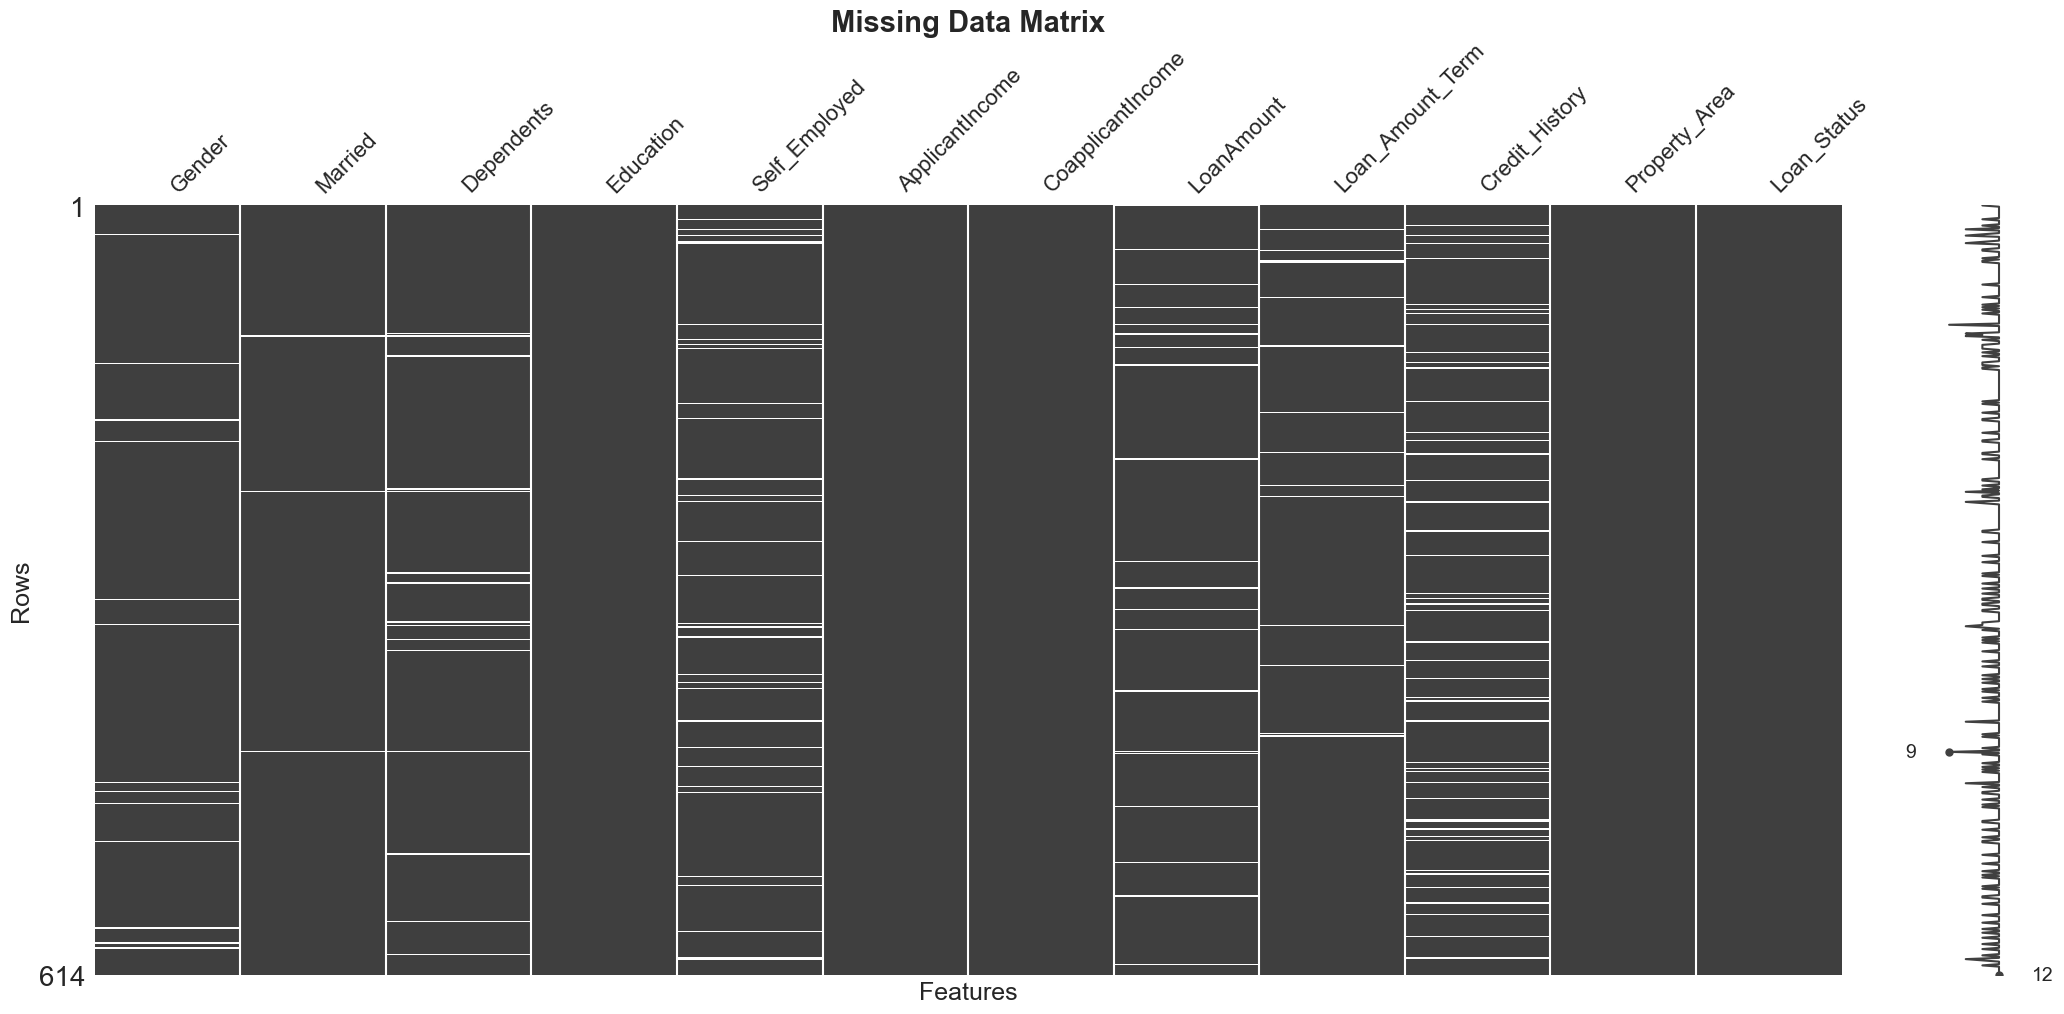

In [4]:
# Visualizing the missing data per feature
msno.matrix(loan_df)

# Customizing missing data matrix plot
plt.title('Missing Data Matrix', weight="bold", fontsize=21)
plt.xlabel('Features', fontsize=18)
plt.ylabel('Rows', fontsize=18)
plt.show()


**Explanation**: The missing data matrix visualizes the missing values per feature. The sparkline at right summarizes the general shape of the data completeness and points out the rows with the maximum and minimum nullity in the dataset (Bilogur, 2022). The maximum nullity that was achieved by a row in the dataset is 10.

## **III. Exploratory Data Analysis**

In [5]:
# Changing value and data type of Credit_History for uniformity in visualization
loan_df['Credit_History'] = loan_df.Credit_History.replace({1 : 'Yes', 0 : 'No'})
# Checking the descriptive statistics of numerical features
print('Descriptive Statistics of Numerical Columns:')
display(loan_df.describe())

# Checking the descriptive statistics of categorical features
print('Descriptive Statistics of Categorical Columns:')
display(loan_df.describe(exclude="number"))

Descriptive Statistics of Numerical Columns:


,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term
count,614.000000,614.000000,592.000000,600.00000
mean,5403.459283,1621.245798,146.412162,342.00000
std,6109.041673,2926.248369,85.587325,65.12041
min,150.000000,0.000000,9.000000,12.00000
25%,2877.500000,0.000000,100.000000,360.00000
50%,3812.500000,1188.500000,128.000000,360.00000
75%,5795.000000,2297.250000,168.000000,360.00000
max,81000.000000,41667.000000,700.000000,480.00000


Descriptive Statistics of Categorical Columns:


,Gender,Married,Dependents,Education,Self_Employed,Credit_History,Property_Area,Loan_Status
count,601,611,599,614,582,564,614,614
unique,2,2,4,2,2,2,3,2
top,Male,Yes,0,Graduate,No,Yes,Semiurban,Y
freq,489,398,345,480,500,475,233,422


### 3.1 Univariate Analysis

#### 3.1.1 Numerical Features

*a.) Applicant Income*

In [6]:
# Create a histogram
fig = px.histogram(loan_df, x="ApplicantIncome", color="Loan_Status", text_auto=True, color_discrete_sequence=discrete_color_scheme, marginal="box", title="<b>Applicant Income Distribution</b><br>Categorized by Loan Status")

# Add borders to the bars
fig.update_traces(marker_line_width=1,marker_line_color="black")
# Add borders to the plot
fig.update_xaxes(showline=True,
         linecolor='black',
         mirror=True)
fig.update_yaxes(showline=True,
         linecolor='black',
         mirror=True)

# Show the histogram
fig.show()

**Insights:** Based on the histogram plot and box subplot above, most of the income of applicants range from 150 to 10,000+. It can also be seen that outliers are evident.

*b.) Co-applicant Income*

In [7]:
# Create a histogram
fig = px.histogram(loan_df, x="CoapplicantIncome", color="Loan_Status", text_auto=True, color_discrete_sequence=discrete_color_scheme, marginal="box", title="<b>Co-applicant Income Distribution</b><br>Categorized by Loan Status")

# Add borders to the bars
fig.update_traces(marker_line_width=1,marker_line_color="black")
# Add borders to the plot
fig.update_xaxes(showline=True,
         linecolor='black',
         mirror=True)
fig.update_yaxes(showline=True,
         linecolor='black',
         mirror=True)

# Show the histogram
fig.show()

**Insights:** Based on the histogram plot and box subplot above, most of the income of co-applicants range from 0 to 5,700. It can also be seen that there are outliers.

*c.) Loan Amount*

In [8]:
# Create a histogram
fig = px.histogram(loan_df, x="LoanAmount", color="Loan_Status", text_auto=True, color_discrete_sequence=discrete_color_scheme, marginal="box", title="<b>Loan Amount Distribution</b><br>Categorized by Loan Status")

# Add borders to the bars
fig.update_traces(marker_line_width=1,marker_line_color="black")
# Add borders to the plot
fig.update_xaxes(showline=True,
         linecolor='black',
         mirror=True)
fig.update_yaxes(showline=True,
         linecolor='black',
         mirror=True)

# Show the histogram
fig.show()

**Insights:** Based on the histogram plot and box subplot above, the loan amount that applicants request range from 9 to 290 (loan amount is in thousands). It can also be seen that outliers are evident.

*d.) Loan Term*

In [9]:
# Create a histogram
fig = px.histogram(loan_df, x="Loan_Amount_Term", color="Loan_Status", text_auto=True, color_discrete_sequence=discrete_color_scheme, marginal="box", title="<b>Loan Term Distribution</b><br>Categorized by Loan Status")

# Add borders to the bars
fig.update_traces(marker_line_width=1,marker_line_color="black")
# Add borders to the x and y-axes to the plot
fig.update_xaxes(showline=True,
         linecolor='black',
         mirror=True)
fig.update_yaxes(showline=True,
         linecolor='black',
         mirror=True)

# Show the histogram
fig.show()

**Insights:** Based on the histogram plot and box subplot above, majority of the applicants choose a loan term of 360 months.

#### 3.1.2. Categorical Features

*a.) Count plots of Categorical Features*

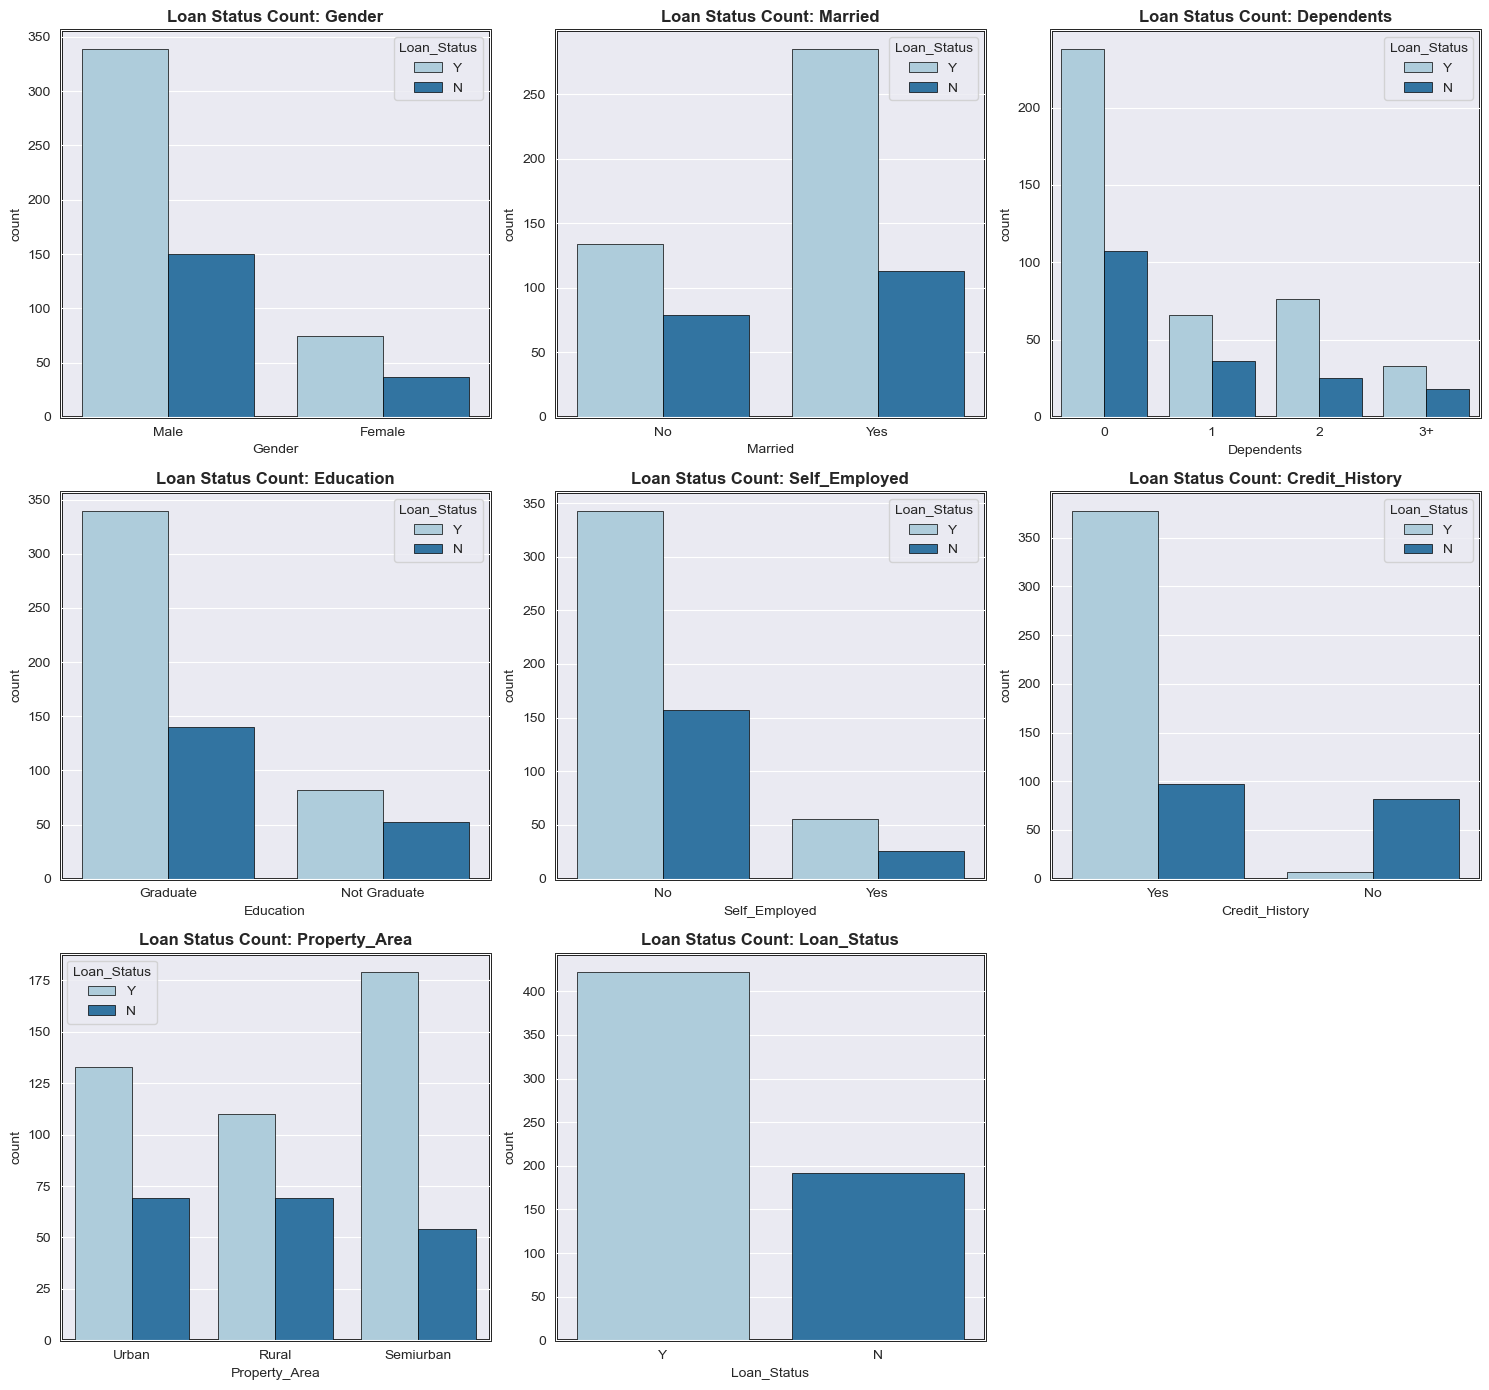

Ratio of Loan_Status
Y    0.69
N    0.31
Name: proportion, dtype: float64


In [10]:
# Create a figure containing 3 (rows) x 3 (columns) subplots
fig, axs = plt.subplots(3, 3, figsize=(15,14))
# List of categorical features
categorical_features = loan_df.select_dtypes(exclude='number').columns.to_list()

# Create a count plot for each categorical feature categorizing them by loan status
for ax, column in zip(axs.flat, categorical_features):
    if categorical_features != "Loan_Status":
        sns.countplot(data=loan_df, x=column, hue="Loan_Status", ax=ax, edgecolor="black", linewidth=0.5)
        ax.set_title(f"Loan Status Count: {column}", weight="bold")
        ax.patch.set_linewidth(2)
        ax.patch.set_edgecolor('black')
    else:
        sns.countplot(data=loan_df, x=column, ax=ax)
# Since we have 8 features in total, we delete the remaining unused subplot
for ax in axs.flat[len(categorical_features):]:
    fig.delaxes(ax)
    
# Auto-fit the subplots
plt.tight_layout()
# Show the figure
plt.show()

# Show the ratio of applicant who were approved and not
print(f"Ratio of {round(loan_df.Loan_Status.value_counts(normalize=True), 2)}")

**Insights:** As observed from the count plots, most of the applicants who were approved for a house loan have the following independent characteristics: male, married, have 0 dependents, have graduated, are not self-employed, have a good credit history, or are applying for a semi-urban property. Lastly, it can be seen that there are 38% more applicants who were approved for a house loan compared to those who weren’t in the dataset.

### 3.2. Bivariate Analysis

*a.) Correlation between Numerical Features*

In [11]:
# Create pairwise correlation of numerical features using Pearson Correlation
loan_corr_df = loan_df.corr(method='pearson', numeric_only=True).round(2)

# Create a dataframe with the same shape as the loan_corr_df but having the values as 0s
zeroes_mask = np.zeros_like(loan_corr_df, dtype=bool)
# From the dataframe filled with zeroes, assign True values to the top triangle of the dataframe
zeroes_mask[np.triu_indices_from(zeroes_mask)] = True

# Use the zeroes_mask to  replace the values in the top triangle of loan_corr_df to Nans
loan_corr_viz = loan_corr_df.mask(zeroes_mask).dropna(how='all').dropna(axis=1, how='all')
# Create lower triangle correlation map
fig = px.imshow(loan_corr_viz, text_auto=True, color_continuous_scale=continuous_color_scheme, title="<b>Correlation Heat Map</b><br>Numerical Features").update_xaxes(showgrid=False).update_yaxes(showgrid=False)

# Show figure
fig.show()

**Insights:** It can be observed in the correlation heat map that the highest correlation value achieved is 0.57, which is between `LoanAmount` and `ApplicantIncome`. The strength of this relationship is considered moderate, as it falls within the range of 0.5 to 0.75 (Bobbitt, 2020).

*b.) Scatter plot of Loan Amount and Applicant Income*

In [12]:
# Create scatter plot and plot trendline using the ordinary least squares model
fig = px.scatter(loan_df, x="ApplicantIncome", y="LoanAmount", title="<b>Loan Amount Vs. Applicant Income</b><br>Pearson r=0.57, Coefficient of Determination R^2=0.33", color_discrete_sequence=discrete_color_scheme, trendline="ols")

# Add marker line
fig.update_traces(marker_line_width=1,marker_line_color="black")
# Add borders to the x and y-axes to the plot
fig.update_xaxes(showline=True,
         linecolor='black',
         mirror=True)
fig.update_yaxes(showline=True,
         linecolor='black',
         mirror=True)

# Show the figure
fig.show()

**Insights:** The moderate strength of positve linear relationship (pearson r=0.57) between the loan amount and applicant income is presented in the scatter plot above. The trend line is based on the ordinary least squares model with a coefficient of determination (R^2) of 0.33, which means that 33% of the variance of the loan amount (dependent variable) is explained by the applicant income (dependent variable). A coefficient of determination closer to 1 means that the model explains the variance in the data well (Turney, 2022). Since the coefficient of determination in our model is 0.33, it only partially explains the variance in the data.

## **IV. Data Pre-processing**

In [13]:
# Create a copy of the original loan dataframe
model_df = loan_df.copy()

### 4.1. Splitting the data into training and testing set

In [14]:
# Drop Loan_Status column
X = model_df.drop('Loan_Status', axis=1)
# Set Loan_Status as the target variable and label-encode values
y = model_df.Loan_Status.replace({'Y': 1, 'N': 0})

# Split the data into train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Compute the target class ratio of approved and not approved applicants for train and test sets
print(f"Train Target Class Ratio:\n{round(y_train.value_counts(normalize=True), 2)}\n")
print(f"Test Target Class Ratio:\n{round(y_test.value_counts(normalize=True), 2)}")

Train Target Class Ratio:
Loan_Status
1    0.69
0    0.31
Name: proportion, dtype: float64

Test Target Class Ratio:
Loan_Status
1    0.69
0    0.31
Name: proportion, dtype: float64


### 4.2. Pre-processing Pipeline Creation

In [15]:
# Store numerical features in a list
numerical_features = X_train.select_dtypes(include='number').columns.to_list()
# Store categorical features in a list
categorical_features = X_train.select_dtypes(exclude='number').columns.to_list()

# Create the machine learning pipeline for imputing numerical and categorical features
numerical_pipeline = Pipeline(steps=[
    ('impute', KNNImputer(n_neighbors=5)), # Impute using the KNN machine learning algorithm with 5 neighbors as a parameter
    ('scaler', RobustScaler()) # Scale the data using the Robust Scaler to scale numerical features in the range of the quantile of the data
])
categorical_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')), # Impute using the mode of the feature
    ('one-hot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)) # One-hot encode categorical features
])

# Combine the numerical and categorical pipelines into one using the ColumnTransformer
num_cat_pipeline = ColumnTransformer(transformers=[
    ('numeric', numerical_pipeline, numerical_features),
    ('categorical', categorical_pipeline, categorical_features)
], verbose_feature_names_out=False)

In [16]:
# Apply the combined pipeline to the X training set
X_train_transf = num_cat_pipeline.fit_transform(X_train)
X_test_transf = num_cat_pipeline.fit_transform(X_test)
# Create a dataframe for the transformed predictor variables
X_train_transf = pd.DataFrame(X_train_transf, columns=num_cat_pipeline.get_feature_names_out())


### 4.3. Balancing Target Class Counts (Synthetic Minority Over-sampling Technique)

In [17]:
# Initialize SMOTE
oversample = SMOTE(random_state=42)
# Apply it to the transformed training data
X_train_final, y_train_final = oversample.fit_resample(X_train_transf, y_train)
# Create a dataframe of the oversampled training data
X_train_final = pd.DataFrame(X_train_final, columns=X_train_final.columns)

In [18]:
# Compare the target class counts of original and oversampled data
print(f"Original Target Class Counts:\n{y_train.value_counts()}\n")
print(f"Oversampled Target Class Counts:\n{y_train_final.value_counts()}")

Original Target Class Counts:
Loan_Status
1    337
0    154
Name: count, dtype: int64

Oversampled Target Class Counts:
Loan_Status
1    337
0    337
Name: count, dtype: int64


## **V. Feature Selection**

**Note**: The train-test split was done before doing feature selection through the wrapper method to avoid data leakage to the test set.

### 5.1. Wrapper Method (Recursive Feature Elimination with Cross-Validation)

In [19]:
# Original shape of transformed training set
X_train_final.shape

(674, 21)

In [20]:
# Initialize Decision Tree Classifier as the estimator
estimator = DecisionTreeClassifier(random_state=42)
# Define your cross-validation strategy
cv = StratifiedKFold(5, shuffle=True, random_state=42)
# Initialize RFECV setting the scoring metric to accuracy and the minimum # of features to select to 3
rfecv = RFECV(estimator=estimator, step=1, cv=cv, scoring='accuracy', min_features_to_select=3)
rfecv.fit(X_train_final, y_train_final)

RFECV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
      estimator=DecisionTreeClassifier(random_state=42),
      min_features_to_select=3, scoring='accuracy')

a.) RFECV Results Dataframe Ordered by Accuracy

In [21]:
# Convert result dictionary to a dataframe
result_df = pd.DataFrame.from_dict(rfecv.cv_results_, orient='columns').sort_values(by='mean_test_score', ascending=False)
result_df

,mean_test_score,std_test_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,n_features
15,0.773079,0.049648,0.748148,0.718519,0.837037,0.733333,0.828358,18
18,0.773068,0.044055,0.748148,0.718519,0.829630,0.748148,0.820896,21
9,0.771598,0.044953,0.740741,0.718519,0.822222,0.748148,0.828358,12
14,0.771587,0.044493,0.748148,0.725926,0.829630,0.733333,0.820896,17
12,0.768612,0.044508,0.748148,0.718519,0.829630,0.733333,0.813433,15
10,0.767120,0.040183,0.725926,0.725926,0.822222,0.755556,0.805970,13
8,0.764179,0.043952,0.725926,0.725926,0.814815,0.733333,0.820896,11
11,0.762687,0.047247,0.725926,0.703704,0.822222,0.748148,0.813433,14
16,0.759701,0.045064,0.740741,0.696296,0.822222,0.740741,0.798507,19
17,0.758253,0.051761,0.718519,0.711111,0.822222,0.718519,0.820896,20


b.) Line plot of Accuracy Relative to the Number of Features

In [22]:
# Retrieve the mean test scores for the chosen features and round to 3 decimal places
scores = list(rfecv.cv_results_['mean_test_score'].round(3))
# Create the a list range for the number of features
number_features = list(range(rfecv.cv_results_['n_features'].min(), rfecv.cv_results_['n_features'].max()+1))

# Create a line plot 
fig = px.line(x=number_features, y=scores, markers=True, text=scores, color_discrete_sequence=discrete_color_scheme, title="<b>Accuracy Score Vs. Number of Features</b>")

# Add data point annotation and adjust marker size
fig.update_traces(textposition="top left", marker=dict(size=10))

# Add borders in the x and y-axes
fig.update_xaxes(showline=True,
         linecolor='black',
         mirror=True)
fig.update_yaxes(showline=True,
         linecolor='black',
         mirror=True)

# Customize x-axis step, font of annotations, and axes titles
fig.update_layout(xaxis={"dtick":1}, font=dict(size=12), xaxis_title="Number of features", yaxis_title="Accuracy")

# Show figure
fig.show()

# Print the selected features
print(f"Number of selected features thru RFECV: {len(rfecv.get_feature_names_out())}\n")
print(f"Selected features thru RFECV:\n{rfecv.get_feature_names_out()}")


Number of selected features thru RFECV: 18

Selected features thru RFECV:
['ApplicantIncome' 'CoapplicantIncome' 'LoanAmount' 'Loan_Amount_Term'
 'Gender_Female' 'Gender_Male' 'Married_No' 'Married_Yes' 'Dependents_0'
 'Dependents_1' 'Dependents_3+' 'Education_Graduate'
 'Education_Not Graduate' 'Self_Employed_No' 'Credit_History_Yes'
 'Property_Area_Rural' 'Property_Area_Semiurban' 'Property_Area_Urban']


**Insights:** It can be observed that the RFECV algorithm has selected all 21 features of the final transformed training data reaching an accuracy of 77.2%. As presented in the line plot, the performance of the model plateaus after going beyond 10 features and then reaching its maximum accuracy at 21 features.

## **VI. Modeling**

### 6.1. Modeling Pipeline Creation

In [23]:
# Store numerical features in a list
numerical_features_models = X_train_final.select_dtypes(include='number').columns.to_list()
# Store categorical features in a list
categorical_features_model = X_train_final.select_dtypes(exclude='number').columns.to_list()

# Combine the numerical and categorical pipelines into one using the ColumnTransformer
num_cat_model_pipeline = ColumnTransformer(transformers=[
    ('numeric', numerical_pipeline, numerical_features_models),
    ('categorical', categorical_pipeline, categorical_features_model)
], verbose_feature_names_out=False)

modeling_pipeline = Pipeline(steps=[
    ('preprocess', num_cat_model_pipeline),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

### 6.2. Hyperparameter dictionary

In [24]:
# Create hyperparameter space dictionary
param_dict = [
    {
        'classifier': [DecisionTreeClassifier(random_state=42)],
        'classifier__criterion': ['gini', 'entropy'],
        'classifier__max_depth': [None, 10, 20],
        'classifier__min_samples_split': randint(2, 6),
        'classifier__min_samples_leaf': randint(1, 4),
        'classifier__max_features': ['auto', 'sqrt']
    },
    {
        'classifier': [RandomForestClassifier(random_state=42)],
        'classifier__n_estimators': randint(50, 150),
        'classifier__max_depth': [None, 10, 20],
        'classifier__min_samples_split': randint(2, 6),
        'classifier__min_samples_leaf': randint(1, 4),
        'classifier__max_features': ['auto', 'sqrt'],
        'classifier__bootstrap': [True, False]
    },
    {
        'classifier': [SVC(random_state=42)],
        'classifier__C': uniform(0.1, 10),
        'classifier__kernel': ['linear', 'rbf'],
        'classifier__gamma': ['scale', 'auto']  # Only used if kernel='rbf'
    }
]
# Instantiate random search using the modeling pipeline and hyperparameter space dictionary
search = RandomizedSearchCV(modeling_pipeline, param_dict, n_iter=10, cv=5, verbose=1, random_state=42, n_jobs=-1)
search.fit(X_train_final, y_train_final)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocess',
                                              ColumnTransformer(transformers=[('numeric',
                                                                               Pipeline(steps=[('impute',
                                                                                                KNNImputer()),
                                                                                               ('scaler',
                                                                                                RobustScaler())]),
                                                                               ['ApplicantIncome',
                                                                                'CoapplicantIncome',
                                                                                'LoanAmount',
                                                                                'Loan_Amount_Term',
                                                                                'Gender_Female',
                                                                                'Gender_Male',
                                                                                'Married_No',
                                                                                'Married_Yes',
                                                                                'Dependents_0',
                                                                                'Dependents_1',
                                                                                'Dependents_2',
                                                                                'D...
                                         'classifier__min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000023BFB53F890>,
                                         'classifier__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000023BFB53FA40>},
                                        {'classifier': [SVC(random_state=42)],
                                         'classifier__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000023BFB53F440>,
                                         'classifier__gamma': ['scale', 'auto'],
                                         'classifier__kernel': ['linear',
                                                                'rbf']}],
                   random_state=42, verbose=1)

In [25]:
# Check the results of from the hyperparameter tuning
model_result_df = pd.DataFrame.from_dict(search.cv_results_, orient='columns')
model_result_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier,param_classifier__C,param_classifier__gamma,param_classifier__kernel,param_classifier__criterion,param_classifier__max_depth,...,param_classifier__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,47.278835,8.766896,0.005241,0.001085,SVC(random_state=42),8.065430,scale,linear,NaN,NaN,...,NaN,"{'classifier': SVC(random_state=42), 'classifi...",0.696296,0.681481,0.725926,0.762963,0.731343,0.719602,0.028476,6
1,0.030220,0.016825,0.007750,0.002965,DecisionTreeClassifier(random_state=42),NaN,NaN,NaN,gini,20,...,NaN,{'classifier': DecisionTreeClassifier(random_s...,0.644444,0.681481,0.762963,0.762963,0.783582,0.727087,0.054177,5
2,0.038213,0.002494,0.016282,0.002708,SVC(random_state=42),4.692489,scale,rbf,NaN,NaN,...,NaN,"{'classifier': SVC(random_state=42), 'classifi...",0.696296,0.725926,0.459259,0.525926,0.507463,0.582974,0.107274,9
3,0.034600,0.000556,0.016131,0.001981,SVC(random_state=42),0.305845,auto,rbf,NaN,NaN,...,NaN,"{'classifier': SVC(random_state=42), 'classifi...",0.703704,0.703704,0.629630,0.718519,0.716418,0.694395,0.032969,7
4,0.255746,0.017496,0.016398,0.005497,RandomForestClassifier(random_state=42),NaN,NaN,NaN,NaN,10,...,125.0,{'classifier': RandomForestClassifier(random_s...,0.770370,0.740741,0.859259,0.925926,0.932836,0.845826,0.078618,2
5,0.291282,0.016133,0.015120,0.002957,RandomForestClassifier(random_state=42),NaN,NaN,NaN,NaN,None,...,140.0,{'classifier': RandomForestClassifier(random_s...,0.740741,0.770370,0.866667,0.933333,0.940299,0.850282,0.082042,1
6,0.035112,0.003497,0.014616,0.001648,SVC(random_state=42),4.098610,auto,rbf,NaN,NaN,...,NaN,"{'classifier': SVC(random_state=42), 'classifi...",0.733333,0.792593,0.762963,0.777778,0.805970,0.774527,0.025125,3
7,0.030630,0.004403,0.016374,0.002894,SVC(random_state=42),4.660700,scale,rbf,NaN,NaN,...,NaN,"{'classifier': SVC(random_state=42), 'classifi...",0.696296,0.725926,0.459259,0.525926,0.514925,0.584467,0.106261,8
8,0.032115,0.002094,0.014399,0.004124,SVC(random_state=42),3.924620,auto,rbf,NaN,NaN,...,NaN,"{'classifier': SVC(random_state=42), 'classifi...",0.725926,0.792593,0.762963,0.770370,0.805970,0.771564,0.027511,4
9,0.016080,0.002749,0.000000,0.000000,DecisionTreeClassifier(random_state=42),NaN,NaN,NaN,gini,None,...,NaN,{'classifier': DecisionTreeClassifier(random_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10


In [26]:
# Sort by rank_test_score and get the top 5 results
top_5_results = model_result_df.nsmallest(5, 'rank_test_score')

# Extract the best estimators and their parameters
top_5_models = top_5_results['params'].values
top_5_scores = top_5_results['mean_test_score'].values

top_5_results[['params', 'mean_test_score']]

,params,mean_test_score
5,{'classifier': RandomForestClassifier(random_s...,0.850282
4,{'classifier': RandomForestClassifier(random_s...,0.845826
6,"{'classifier': SVC(random_state=42), 'classifi...",0.774527
8,"{'classifier': SVC(random_state=42), 'classifi...",0.771564
1,{'classifier': DecisionTreeClassifier(random_s...,0.727087


In [27]:
# Best estimator and its hyperparameters
best_model = search.best_estimator_
best_model

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('impute',
                                                                   KNNImputer()),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['ApplicantIncome',
                                                   'CoapplicantIncome',
                                                   'LoanAmount',
                                                   'Loan_Amount_Term',
                                                   'Gender_Female',
                                                   'Gender_Male', 'Married_No',
                                                   'Married_Yes',
                                                   'Dependents_0',
                                                   'Dependents_1',
                                                   'Dependents_2',
                                                   'Dependents_3+',
                                                   'Education_Graduate'...
                                                   'Property_Area_Rural',
                                                   'Property_Area_Semiurban',
                                                   'Property_Area_Urban']),
                                                 ('categorical',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('one-hot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  [])],
                                   verbose_feature_names_out=False)),
                ('classifier',
                 RandomForestClassifier(bootstrap=False, n_estimators=140,
                                        random_state=42))])

In [28]:
# Using the numerical and categorical pipeline, transform X_test
X_test_transf = num_cat_pipeline.fit_transform(X_test)
X_test_transf = pd.DataFrame(X_test_transf, columns=num_cat_pipeline.get_feature_names_out())
# Using the best model in predicting the target from the test set
y_pred = best_model.predict(X_test_transf)

In [29]:
# Show the testing evaluation metrics of the best model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.55      0.61        38
           1       0.82      0.88      0.85        85

    accuracy                           0.78       123
   macro avg       0.75      0.72      0.73       123
weighted avg       0.77      0.78      0.77       123



**Insights:** The classification report shows the performance of the model in the test set. It can be seen that the accuracy decreased from 85% to 78%, which is expected because the model would always perform better in the training set. The precision of the model is 75% whereas the recall is 72%, indicating the the model can differentiate true positive from false positives better compared to differentiating true positives from all the expected true positves or ground truth. Lastly, the f1-score, which is the harmonic mean of precision and recall, is 73%.

## **VII. SHAP (SHapley Additive exPlanations)**

In [30]:
# Redo fitting without using the pipeline because shap tree explainer cannot read pipeline fitted models
clf_non_pipeline = RandomForestClassifier(bootstrap=False, n_estimators=140, random_state=42)

clf_non_pipeline.fit(X_train_final, y_train_final)

y_pred_non_pipeline = clf_non_pipeline.predict(X_test_transf)

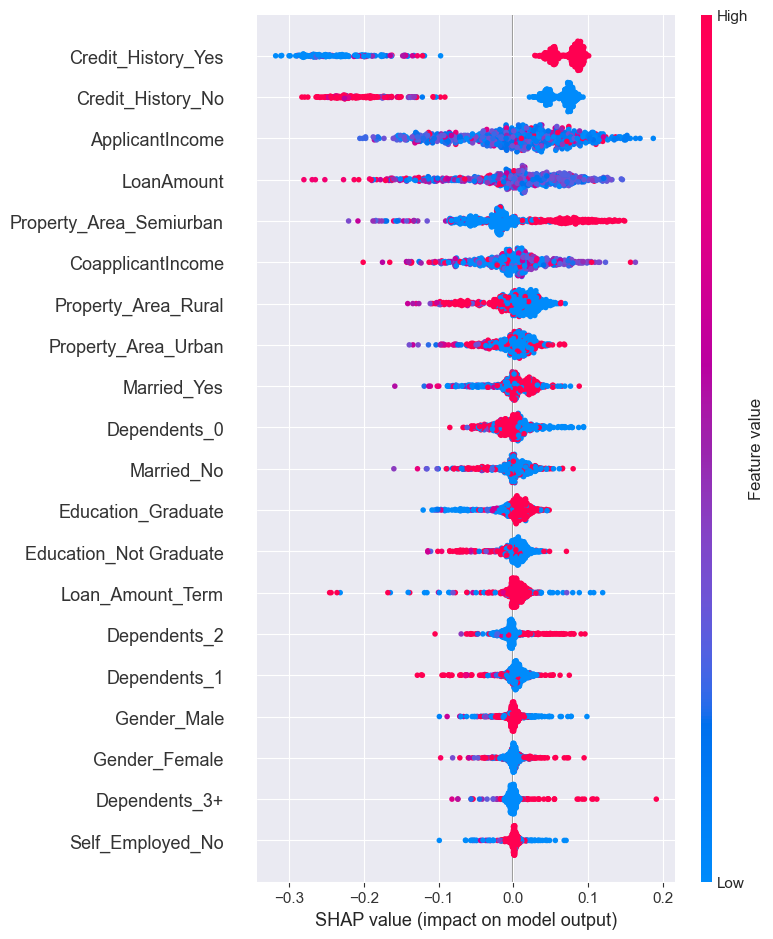

In [31]:
# Instantiate shap
shap.initjs()
samples = X_train_final
explainer = shap.TreeExplainer(clf_non_pipeline)
shap_values = explainer.shap_values(samples, approximate=False, check_additivity=False)

# Create shap summary plot
shap.summary_plot(shap_values[:,:,1], samples)

In [32]:
def make_shap_waterfall_plot(shap_values, features, num_display=20):
    '''
    A function for building SHAP waterfall plot which will be used to visualize the most important features in a descending order.

        Parameters:
        shap_values (list): SHAP values obtained from a model
        features (pd.DataFrame): a list of features used in a model
        num_display (int): number of features to display

        Returns:
        matplotlib.pyplot plot: SHAP waterfall plot
    '''

    column_list = features.columns
    feature_ratio = (np.abs(shap_values).sum(0) / np.abs(shap_values).sum()) * 100
    column_list = column_list[np.argsort(feature_ratio)[::-1]]
    feature_ratio_order = np.sort(feature_ratio)[::-1]
    cum_sum = np.cumsum(feature_ratio_order)
    column_list = column_list[:num_display]
    feature_ratio_order = feature_ratio_order[:num_display]
    cum_sum = cum_sum[:num_display]

    num_height = 0
    if (num_display >= 20) & (len(column_list) >= 20):
        num_height = (len(column_list) - 20) * 0.4

    fig, ax1 = plt.subplots(figsize=(8, 8  + num_height))
    ax1.plot(cum_sum[::-1], column_list[::-1], c='blue', marker='o')
    ax2 = ax1.twiny()
    ax2.barh(column_list[::-1], feature_ratio_order[::-1], alpha=0.6)

    ax1.grid(True)
    ax2.grid(False)
    ax1.set_xticks(np.arange(0, round(cum_sum.max(), -1)+1, 10))
    ax2.set_xticks(np.arange(0, round(feature_ratio_order.max(), -1)+1, 10))
    ax1.set_xlabel('Cumulative Ratio')
    ax2.set_xlabel('Composition Ratio')
    ax1.tick_params(axis="y", labelsize=13)
    plt.ylim(-1, len(column_list))
    fig.show()

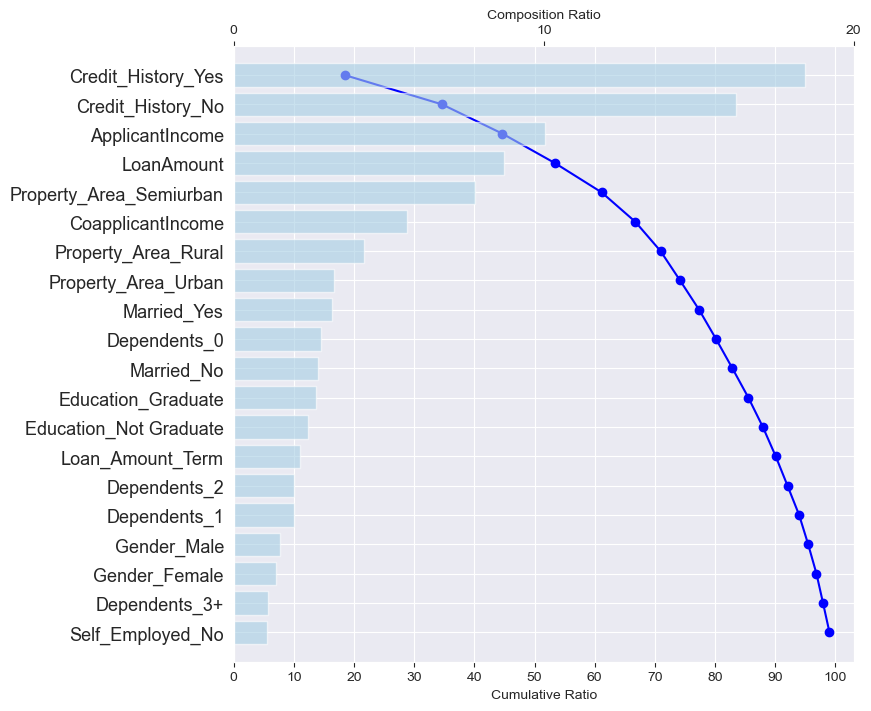

In [33]:
make_shap_waterfall_plot(shap_values[:,:,1], samples)

**Insights:** It can be seen in the horizontal pareto plot above that Credit_History_Yes explains more than **18%** of the explainability of the model prediction for house loan approval.This is followed by Credit_History_No (16%), ApplicantIncome(10%), LoanAmount(8%), and Property_Area_Semiurban(6%).

In [34]:
# Show SHAP importance values
feature_names = X_train_final.columns

rf_resultX = pd.DataFrame(shap_values[:,:,1], columns = feature_names)

vals = np.abs(rf_resultX.values).mean(0)

shap_importance = pd.DataFrame(list(zip(feature_names, vals)),
                                  columns=['col_name','feature_importance_vals'])
shap_importance.sort_values(by=['feature_importance_vals'],
                               ascending=False, inplace=True)
shap_importance

,col_name,feature_importance_vals
17,Credit_History_Yes,0.112056
16,Credit_History_No,0.098388
0,ApplicantIncome,0.061029
2,LoanAmount,0.052919
19,Property_Area_Semiurban,0.047272
1,CoapplicantIncome,0.033905
18,Property_Area_Rural,0.025546
20,Property_Area_Urban,0.019666
7,Married_Yes,0.019266
8,Dependents_0,0.017150


In [35]:
# Extract the top 5 features
top_5_features = list(shap_importance.col_name[:5])
top_5_features

['Credit_History_Yes',
 'Credit_History_No',
 'ApplicantIncome',
 'LoanAmount',
 'Property_Area_Semiurban']

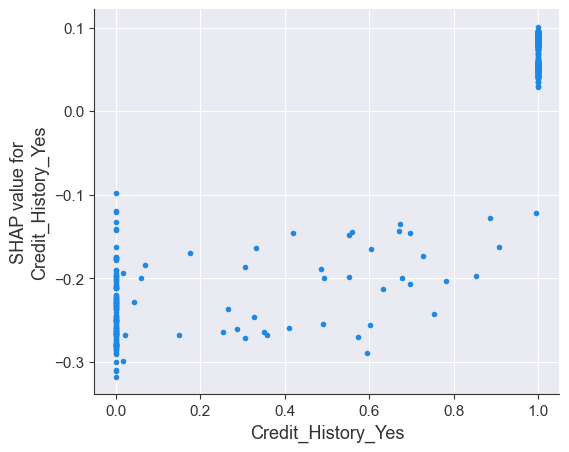

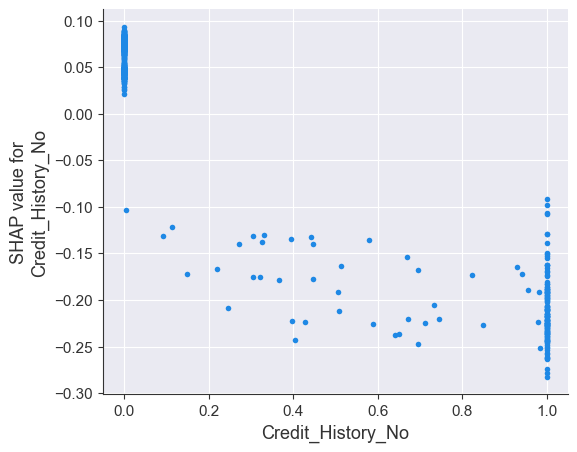

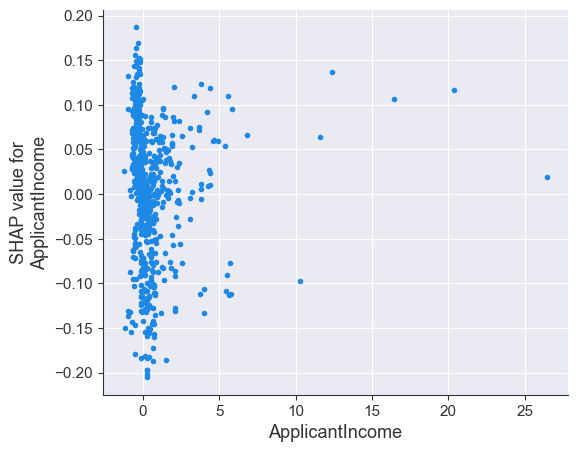

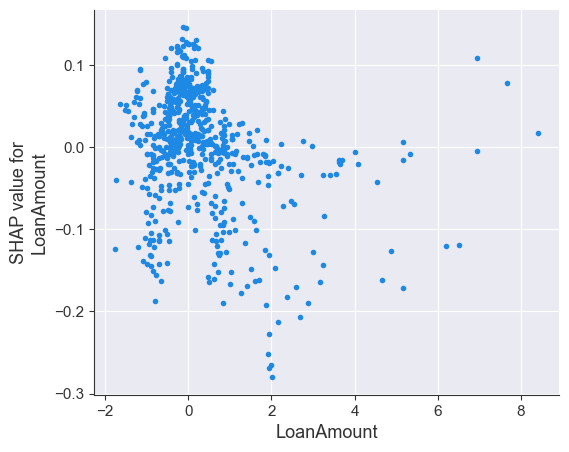

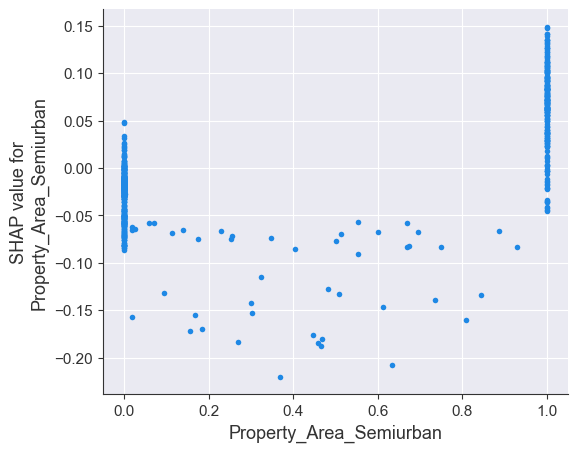

In [36]:
# Create dependence plots for the top 5 features
for feature in top_5_features:
    shap.dependence_plot(feature, shap_values[:,:,1], samples, interaction_index=None)

Based on the summary, pareto, and dependence plots of the top 5 most important features, the applicants who are likely to be approved of a house loan have the following characteristics:
- Has a good credit history
- Has an income of 200 to 10,000 (also basing from the histogram and box plot of approved applicants)
- Applies for a loan amount ranging from 17 to 250 (also basing from the histogram and box plot of approved applicants)
- Loaning for a semi-urban property area

**Business Implication:**
The machine learning model for classifying housing loan applicants has substantial business implications for banks or financial services companies by enhancing decision-making efficiency, improving risk management, and increasing approval accuracy. Analysis of the top five most important features reveals that applicants most likely to be approved typically have a good credit history, earn between 200 and 10,000, request loan amounts ranging from 17 to 250 thousand, and apply for loans for semi-urban properties. By integrating these insights, the model streamlines the loan approval process, reducing manual effort and operational costs while ensuring a more consistent and precise assessment of credit risk. This not only provides a competitive edge and improves customer experience through faster responses but also supports regulatory compliance by maintaining transparent and reliable decision-making criteria. Overall, it drives efficiency, accuracy, and profitability in the loan approval process.

## <span style="color:blue">Summary</span>


The analysis began with data inspection, including the removal of the ID column and checking for nulls and duplicates. The missing data matrix and associated visualizations revealed that the maximum nullity in any row was 10. Exploratory data analysis (EDA) showed that most applicants’ incomes range from 150 to 10,000+, while co-applicants' incomes range from 0 to 5,700. Loan amounts requested typically fall between 9 and 290 thousand, and most applicants select a 360-month loan term. Characteristics of approved applicants often include being male, married, having 0 dependents, being a graduate, not self-employed, having a good credit history, or applying for semi-urban properties. Additionally, the dataset shows a 38% higher approval rate for house loans compared to non-approvals. The correlation heat map indicates a moderate relationship between loan amount and applicant income (r = 0.57), and a scatter plot shows that 33% of the variance in loan amount is explained by applicant income, suggesting a moderate explanatory power of the model.

## <span style="color:blue">Data Preprocessing</span>

In this section, we describe the data preprocessing steps undertaken to prepare the data for modeling, ensuring proper handling and avoiding data leakage. First, the data was split before preprocessing to prevent leakage of information. We maintained the same target class proportions in both training and testing datasets. A preprocessing pipeline was created, incorporating a robust scaler (Geek for geeks, 2024) to handle outliers during the scaling of numerical features and a KNN imputer to address missing values in numerical features. A column transformer was used to integrate numeric and categorical data. To address class imbalance, we applied the Synthetic Minority Over-sampling Technique (SMOTE) to balance target class counts. Finally, feature selection was performed using Recursive Feature Elimination with Cross-Validation (Brownlee, 2020) to enhance model performance.

## <span style="color:blue">Model Development</span>

In this section, we outline the model development process and provide code for the implementation. A modeling pipeline was utilized in conjunction with random search to optimize hyperparameters. Three different models were employed: Random Forest, Decision Tree, and Support Vector Machine (SVM). This approach enabled a comprehensive evaluation of model performance and selection based on their respective strengths and tuning results. The Random Forest Classifier Model has the following hyperparameters: bootstrap=False, n_estimators=140, and random_state=42.

## <span style="color:blue">Model Results</span>

**Training Evaluation Results:**
| Algorithm             | Accuracy |
|-----------------------|----------|
| RandomForestClassifier| 85.02%   |
| SVC                   | 77.30%   |
| DecisionTreeClassifier| 73.60%   |

**Testing Evaluation Results using the Best Model:**
| Algorithm             | Accuracy | Precision| Recall| F1 Score |
|-----------------------|----------|----------|-------|----------|
| RandomForestClassifier| 78%   | 75%       | 72%    | 73%       |


## <span style="color:blue">Model Interpretability</span>

This section explores the key features identified by the best-performing model and provides insights into their significance. Analysis using summary, Pareto, and dependence plots of the top five most important features reveals that applicants most likely to be approved for a house loan typically exhibit the following characteristics: they have a good credit history, earn between 200 and 10,000 (as indicated by histograms and box plots of approved applicants), request loan amounts ranging from 17 to 250 thousand (again supported by histograms and box plots), and apply for loans for semi-urban properties. These features collectively contribute to the model’s predictions and offer a clearer understanding of the factors influencing loan approval.

## <span style="color:blue">Recommendation</span>

To enhance the model's performance, it is recommended to explore a broader hyperparameter space by using GridSearch instead of Random Search. GridSearch systematically tests all possible combinations of hyperparameters, potentially uncovering optimal settings that Random Search might miss. This approach could lead to more refined model tuning and improved accuracy. Additionally, further model improvements could be achieved by incorporating additional features, experimenting with different algorithms, or applying advanced ensemble methods.

## **VIII. References**

- Bobbit, Z. (2020). What is Considered to Be a “Strong” Correlation?. https://www.statology.org/what-is-a-strong-correlation/
- Brownlee, J. (2020). Recursive Feature Elimination (RFE) for Feature Selection in Python. https://machinelearningmastery.com/rfe-feature-selection-in-python/
- Geek for geeks. (2024). ML: Handling Imbalanced Data with SMOTE and Near Miss Algorithm in Python. https://www.geeksforgeeks.org/ml-handling-imbalanced-data-with-smote-and-near-miss-algorithm-in-python/
- Geek for geeks. (2023). StandardScaler, MinMaxScaler and RobustScaler techniques – ML. https://www.geeksforgeeks.org/standardscaler-minmaxscaler-and-robustscaler-techniques-ml/
- Turney, S. (2023). Coefficient of Determination (R²) | Calculation & Interpretation. https://www.scribbr.com/statistics/coefficient-of-determination/